In [5]:
import numpy as np
import pandas as pd
import matplotlib
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import copy
import os
import re
import shutil

from sklearn.tree import export_graphviz
import graphviz

%matplotlib inline
matplotlib.use('module://ipykernel.pylab.backend_inline')

RANDOM_STATE = 25 
# RANDOM_STATE = 42

In [6]:
n_samples =None
memory_experiment = "pm"
remove_na = True

second_visit = 2
gender = None
iqr_coefficient = None # if None then no standrat removal of outliers
outcome = f"z_global_change.0.{second_visit}"
# outcome = f"z_change_snap_game_true_pos_rt_avrg.0.{second_visit}"
# outcome =f"z_change_log_pairs_matching_sum_incorrect.0.{second_visit}"


# outcome = f"z_change_num_memory_max_digits_remembered_correctly.0.{second_visit}"

input_file = f"/projects/prime/ukbb/results_2024/{memory_experiment}_sg_0_{second_visit}_18_06_all_learning/data_with_na.csv"
output_dir = f"/projects/prime/ukbb/results_2024/{memory_experiment}_sg_0_{second_visit}_18_06_all_learning/regressor_all_predictors_{outcome}"

if gender is None:
  output_dir = f"{output_dir}/"
else:
  output_dir = f"{output_dir}_gender_{gender}/"
if not os.path.exists(output_dir):
  os.makedirs(output_dir)



In [7]:
# function for removing outliers via iqr approach
def remove_outliers_iqr(df_, iqr_cf,  outliers):
    print(f"# data points before removing outliers: {len(df_)}")
    if iqr_cf is not None:
        
        lower_bound = {}
        upper_bound = {}
        
        for feat  in outliers:
            print(f"{feat}")
            
            Q1 = df_[feat].quantile(0.25)
            Q3 = df_[feat].quantile(0.75)
            
            IQR = Q3-Q1
            lower_bound[feat] = Q1 - iqr_cf * IQR
            upper_bound[feat] = Q3 + iqr_cf * IQR
            
            
            
        for feat in lower_bound:
            df_= df_[(df_[feat] >= lower_bound[feat]) & (df_[feat] <= upper_bound[feat])]
            
        print(f"# data points after removing outliers: {len(df_)}")
    return(df_)

In [8]:
predictors = ["gender.0", f"time_difference.0.{second_visit}", "age_years.0", "education_level.0", 
              "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0",
               "Syst_bp.0", "Diast_bp.0", "hdl_conv.0", "ldl_conv.0",  "HbA1c_conv.0",  "C_reactive_protein.0",   
               "waist_cm.0",  "bmi_kg_m2.0", 
               "oily_fish_gpday_bradbury.0", "white_fish_gpday_bradbury.0", 
   "red_meat_bradbury_gpd.0", "poultry_gpday_bradbury.0",
   "processed_meat_gpday_bradbury.0", "veg_gpday_bradbury.0",
   "fruit_gpday_bradbury.0", "bread_gpday_bradbury.0", "cheese_gpday_bradbury.0",
    "tea_gpday_bradbury.0", 
    "red_wine_gpd.0", "white_wine_gpd.0", "fortified_gpd.0", "beer_cider_gpd.0", "spirits_gpd.0",
    "aspirin.0",  "anxiety_tr.0", "pain_tr.0", "TAZD_Thiazide.0",  
   "loop_diuretics.0",  "potassium_diuretics.0", "beta_blockers.0", "calcium_antagonists.0", 
   "ARA_II_Antagonists_of_angiotensin_II_receptors.0", "IECA_Angiotensin_converting_enzyme_inhibitors.0",
   "Other_Hypotensive.0","hypochol_statins.0", "hypochol_others.0", "insulin.0", "sulfonylurea.0", "thiazolidinediones.0", "non_sulfonylurea_insulin_secretagogues.0", "metformin_category.0", "vitamins_minerals.0"]

In [9]:
# z global based on pm and sg, 0.7 training, criterion = "friedman_mse", min_samples_split =900, min_samples_leaf = 10
'''predictors = ["gender.0", f"time_difference.0.{second_visit}", "age_years.0", "education_level.0", 
              "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0",
               "Syst_bp.0", "Diast_bp.0", "hdl_conv.0", "ldl_conv.0",  "HbA1c_conv.0",  "C_reactive_protein.0",   
               "waist_cm.0",  "bmi_kg_m2.0", 
               "oily_fish_gpday_bradbury.0", "white_fish_gpday_bradbury.0", 
   "red_meat_bradbury_gpd.0", "poultry_gpday_bradbury.0",
   "processed_meat_gpday_bradbury.0", "veg_gpday_bradbury.0",
   "fruit_gpday_bradbury.0", "bread_gpday_bradbury.0", "cheese_gpday_bradbury.0",
    "tea_gpday_bradbury.0", 
    "red_wine_gpd.0", "white_wine_gpd.0", "fortified_gpd.0", "beer_cider_gpd.0", "spirits_gpd.0",
    "aspirin.0",  "anxiety_tr.0", "pain_tr.0", "TAZD_Thiazide.0",  
   "loop_diuretics.0",  "potassium_diuretics.0", "beta_blockers.0", "calcium_antagonists.0", 
   "ARA_II_Antagonists_of_angiotensin_II_receptors.0", "IECA_Angiotensin_converting_enzyme_inhibitors.0",
   "Other_Hypotensive.0","hypochol_statins.0", "hypochol_others.0", "insulin.0", "sulfonylurea.0", "thiazolidinediones.0", "non_sulfonylurea_insulin_secretagogues.0", "metformin_category.0", "vitamins_minerals.0"]'''

'predictors = ["gender.0", f"time_difference.0.{second_visit}", "age_years.0", "education_level.0", \n              "Diabetes_2.0",  "Dyslipidemia.0", "Depression.0", "Hypertension.0",\n               "Syst_bp.0", "Diast_bp.0", "hdl_conv.0", "ldl_conv.0",  "HbA1c_conv.0",  "C_reactive_protein.0",   \n               "waist_cm.0",  "bmi_kg_m2.0", \n               "oily_fish_gpday_bradbury.0", "white_fish_gpday_bradbury.0", \n   "red_meat_bradbury_gpd.0", "poultry_gpday_bradbury.0",\n   "processed_meat_gpday_bradbury.0", "veg_gpday_bradbury.0",\n   "fruit_gpday_bradbury.0", "bread_gpday_bradbury.0", "cheese_gpday_bradbury.0",\n    "tea_gpday_bradbury.0", \n    "red_wine_gpd.0", "white_wine_gpd.0", "fortified_gpd.0", "beer_cider_gpd.0", "spirits_gpd.0",\n    "aspirin.0",  "anxiety_tr.0", "pain_tr.0", "TAZD_Thiazide.0",  \n   "loop_diuretics.0",  "potassium_diuretics.0", "beta_blockers.0", "calcium_antagonists.0", \n   "ARA_II_Antagonists_of_angiotensin_II_receptors.0", "IECA_Angiotensin_co

In [10]:
df = pd.read_table(input_file, nrows=n_samples,sep =",")
df = df[predictors+[outcome]]
print(f"data set {len(df)} rows")
if remove_na:
    df = df.dropna(axis="rows")
    print(f"cleaned check up db has {len(df)} rows")
    
df = remove_outliers_iqr(df, iqr_coefficient, df.columns)

data set 502204 rows
cleaned check up db has 25590 rows
# data points before removing outliers: 25590


In [11]:
features = [x for x in df.columns if x not in [outcome, outcome]]
# features = [x for x in df.columns if x not in outcome]

In [12]:
print(features)

['gender.0', 'time_difference.0.2', 'age_years.0', 'education_level.0', 'Diabetes_2.0', 'Dyslipidemia.0', 'Depression.0', 'Hypertension.0', 'Syst_bp.0', 'Diast_bp.0', 'hdl_conv.0', 'ldl_conv.0', 'HbA1c_conv.0', 'C_reactive_protein.0', 'waist_cm.0', 'bmi_kg_m2.0', 'oily_fish_gpday_bradbury.0', 'white_fish_gpday_bradbury.0', 'red_meat_bradbury_gpd.0', 'poultry_gpday_bradbury.0', 'processed_meat_gpday_bradbury.0', 'veg_gpday_bradbury.0', 'fruit_gpday_bradbury.0', 'bread_gpday_bradbury.0', 'cheese_gpday_bradbury.0', 'tea_gpday_bradbury.0', 'red_wine_gpd.0', 'white_wine_gpd.0', 'fortified_gpd.0', 'beer_cider_gpd.0', 'spirits_gpd.0', 'aspirin.0', 'anxiety_tr.0', 'pain_tr.0', 'TAZD_Thiazide.0', 'loop_diuretics.0', 'potassium_diuretics.0', 'beta_blockers.0', 'calcium_antagonists.0', 'ARA_II_Antagonists_of_angiotensin_II_receptors.0', 'IECA_Angiotensin_converting_enzyme_inhibitors.0', 'Other_Hypotensive.0', 'hypochol_statins.0', 'hypochol_others.0', 'insulin.0', 'sulfonylurea.0', 'thiazolidined

In [13]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df[outcome], train_size = 0.7, random_state = RANDOM_STATE)

In [14]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')

train samples: 17913
validation samples: 7677


In [15]:
min_samples_s = [2,10, 30, 50, 100, 350, 200, 300, 350, 400, 450, 500, 550, 600, 650, 700, 800, 900, 1000] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_s = [1,2, 3, 4, 8, 16, 17, 18, 19, 20, 21, 22] # None means that there is no depth limit.

In [16]:
mae_list_train = []
mse_list_train = []
r2_list_train = []
mae_list_val = []
mse_list_val = []
r2_list_val = []
for min_samples_split in min_samples_s:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeRegressor(criterion='friedman_mse', 
        min_samples_split = min_samples_split, min_samples_leaf = 10,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    
    mae_train = mean_absolute_error(predictions_train,y_train)
    mae_val = mean_absolute_error(predictions_val,y_val)
    
    mse_train = mean_squared_error(predictions_train,y_train)
    mse_val = mean_squared_error(predictions_val,y_val)
    
    r2_train = r2_score(predictions_train,y_train)
    r2_val = r2_score(predictions_val,y_val)
    
    mae_list_train.append(mae_train)
    mae_list_val.append(mae_val)
    
    mse_list_train.append(mse_train)
    mse_list_val.append(mse_val)
    
    r2_list_train.append(r2_train)
    r2_list_val.append(r2_val)


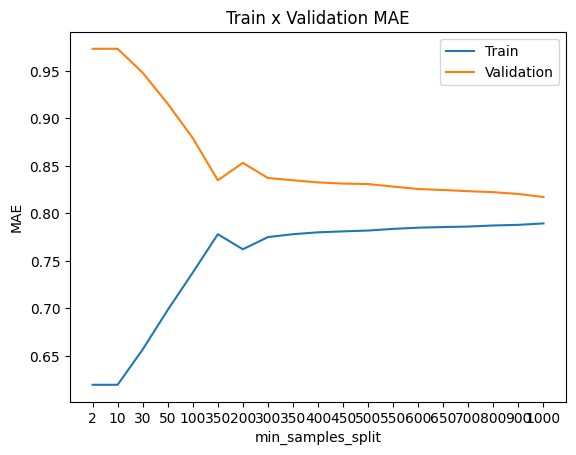

In [17]:
plt.title("Train x Validation MAE")
plt.xlabel('min_samples_split')
plt.ylabel('MAE')
plt.xticks(ticks = range(len(min_samples_s )),labels=min_samples_s)
plt.plot(mae_list_train)
plt.plot(mae_list_val)
plt.legend(['Train','Validation'])
 

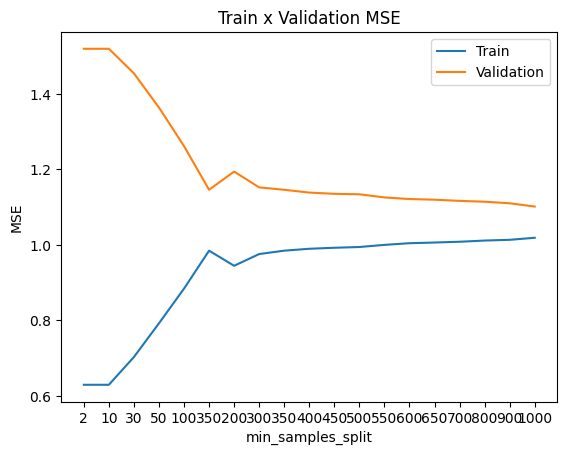

In [18]:
plt.title("Train x Validation MSE")
plt.xlabel('min_samples_split')
plt.ylabel('MSE')
plt.xticks(ticks = range(len(min_samples_s )),labels=min_samples_s)
plt.plot(mse_list_train)
plt.plot(mse_list_val)
plt.legend(['Train','Validation'])

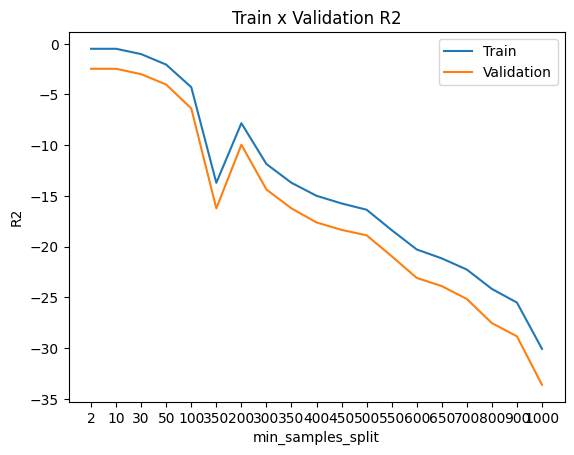

In [19]:
plt.title('Train x Validation R2')
plt.xlabel('min_samples_split')
plt.ylabel('R2')
plt.xticks(ticks = range(len(min_samples_s )),labels=min_samples_s)
plt.plot(r2_list_train)
plt.plot(r2_list_val)
plt.legend(['Train','Validation'])

In [20]:
mae_list_train = []
r2_list_train = []
mae_list_val = []
r2_list_val = []
for max_depth in max_depth_s:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeRegressor(max_depth = max_depth, criterion='friedman_mse', 
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    
    mae_train = mean_absolute_error(predictions_train,y_train)
    mae_val = mean_absolute_error(predictions_val,y_val)
    
    r2_train = r2_score(predictions_train,y_train)
    r2_val = r2_score(predictions_val,y_val)
    
    mae_list_train.append(mae_train)
    mae_list_val.append(mae_val)
    
    r2_list_train.append(r2_train)
    r2_list_val.append(r2_val)



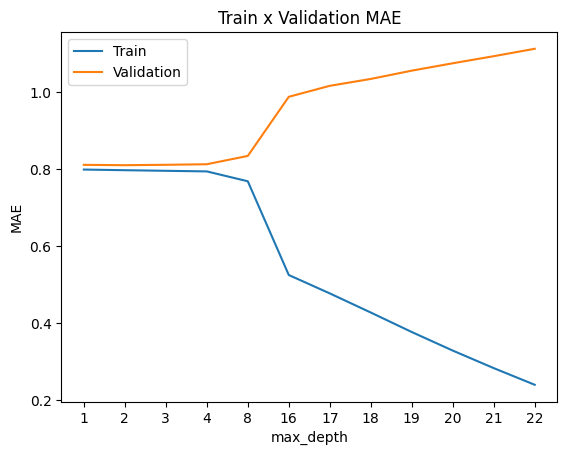

In [21]:
plt.title("Train x Validation MAE")
plt.xlabel('max_depth')
plt.ylabel('MAE')
plt.xticks(ticks = range(len(max_depth_s )),labels=max_depth_s)
plt.plot(mae_list_train)
plt.plot(mae_list_val)
plt.legend(['Train','Validation'])

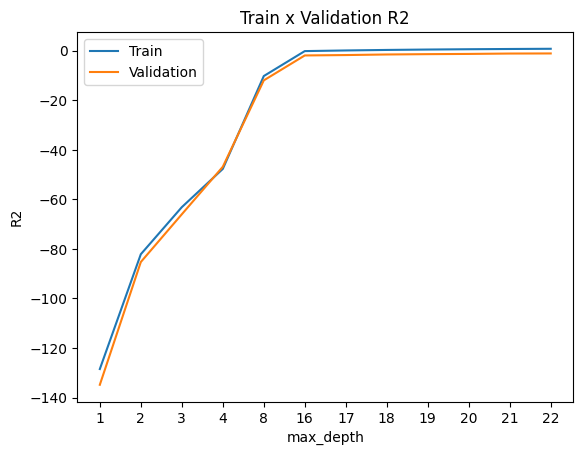

In [22]:
plt.title('Train x Validation R2')
plt.xlabel('max_depth')
plt.ylabel('R2')
plt.xticks(ticks = range(len(max_depth_s )),labels=max_depth_s)
plt.plot(r2_list_train)
plt.plot(r2_list_val)
plt.legend(['Train','Validation'])

In [23]:
min_samples_leaf_s = [20,  40,  60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450]
mae_list_train = []
mse_list_train = []
r2_list_train = []
mae_list_val = []
mse_list_val = []
r2_list_val = []
for min_samples_leaf in min_samples_leaf_s:
    print(f"min samples leaf {min_samples_leaf}")
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeRegressor(criterion='friedman_mse',  max_depth = None,
        min_samples_leaf = min_samples_leaf, 
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    
    mae_train = mean_absolute_error(predictions_train,y_train)
    mae_val = mean_absolute_error(predictions_val,y_val)
    
    mse_train = mean_squared_error(predictions_train,y_train)
    mse_val = mean_squared_error(predictions_val,y_val)
    
    r2_train = r2_score(predictions_train,y_train)
    r2_val = r2_score(predictions_val,y_val)
    
    mae_list_train.append(mae_train)
    mae_list_val.append(mae_val)
    
    mse_list_train.append(mse_train)
    mse_list_val.append(mse_val)
    
    r2_list_train.append(r2_train)
    r2_list_val.append(r2_val)

min samples leaf 20
min samples leaf 40
min samples leaf 60
min samples leaf 70
min samples leaf 80
min samples leaf 90
min samples leaf 100
min samples leaf 125
min samples leaf 150
min samples leaf 175
min samples leaf 200
min samples leaf 250
min samples leaf 300
min samples leaf 350
min samples leaf 400
min samples leaf 450


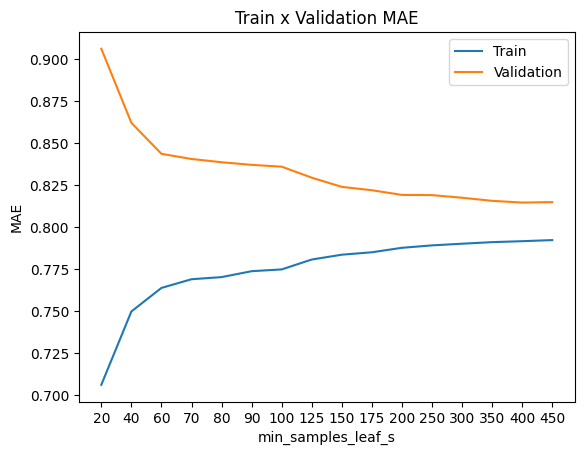

In [24]:
plt.title("Train x Validation MAE")
plt.xlabel('min_samples_leaf_s')
plt.ylabel('MAE')
plt.xticks(ticks = range(len(min_samples_leaf_s )),labels=min_samples_leaf_s)
plt.plot(mae_list_train)
plt.plot(mae_list_val)
plt.legend(['Train','Validation'])

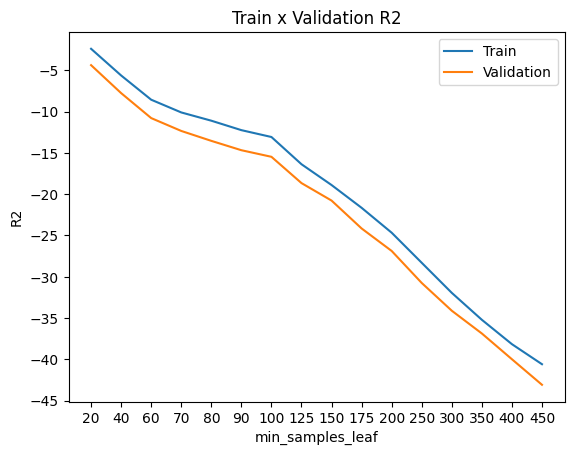

In [25]:
plt.title('Train x Validation R2')
plt.xlabel('min_samples_leaf')
plt.ylabel('R2')
plt.xticks(ticks = range(len(min_samples_leaf_s )),labels=min_samples_leaf_s)
plt.plot(r2_list_train)
plt.plot(r2_list_val)
plt.legend(['Train','Validation'])

In [26]:
# global change on pm, min samples == 900, min elaf = 10. long but reasonable
regressor = DecisionTreeRegressor(min_samples_split = 900, min_samples_leaf = 20, criterion='absolute_error',
                                             random_state = RANDOM_STATE)
regression_tree_model = regressor.fit(X_train,y_train)

print(f"MAE train:\n\t: {mean_absolute_error(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"MAE validation:\n\t: {mean_absolute_error(regression_tree_model.predict(X_val),y_val):.4f}")
print(f"MSE train:\n\t: {mean_squared_error(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"MSE validation:\n\t: {mean_squared_error(regression_tree_model.predict(X_val),y_val):.4f}")
print(f"R2 train:\n\t: {r2_score(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"R2 validation:\n\t: {r2_score(regression_tree_model.predict(X_val),y_val):.4f}")


MAE train:
	: 0.7812
MAE validation:
	: 0.8248
MSE train:
	: 1.0214
MSE validation:
	: 1.1152
R2 train:
	: -20.4125
R2 validation:
	: -22.7663


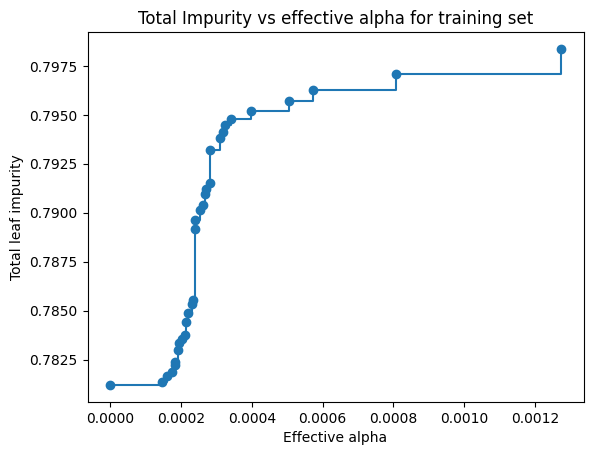

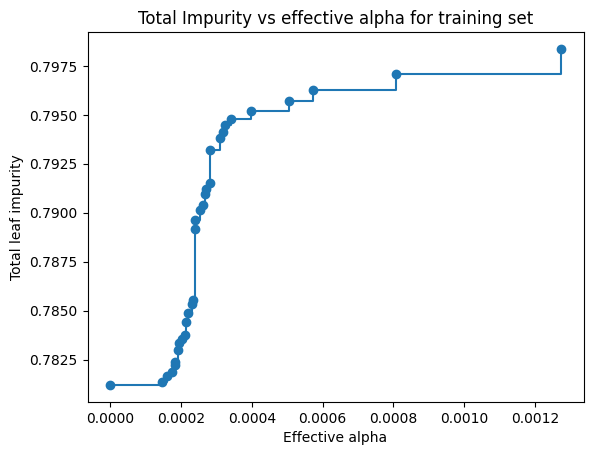

In [27]:
path = regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot effective alphas vs total leaf impurities
plt.figure()
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Total leaf impurity")
plt.title("Total Impurity vs effective alpha for training set")
plt.show()

path = regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot effective alphas vs total leaf impurities
plt.figure()
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Total leaf impurity")
plt.title("Total Impurity vs effective alpha for training set")
plt.show()


In [28]:

mae_list_train = []
mse_list_train = []
r2_list_train = []
mae_list_val = []
mse_list_val = []
r2_list_val = []

for ccp_alpha in ccp_alphas:
    print(f"ccp_alpha: {ccp_alpha}")
    model = DecisionTreeRegressor(min_samples_split = 100, min_samples_leaf = 10, max_depth = None,
                                  ccp_alpha=ccp_alpha,
                                             random_state = RANDOM_STATE)
    model = regressor.fit(X_train,y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    
    mae_train = mean_absolute_error(predictions_train,y_train)
    mae_val = mean_absolute_error(predictions_val,y_val)
    
    mse_train = mean_squared_error(predictions_train,y_train)
    mse_val = mean_squared_error(predictions_val,y_val)
    
    r2_train = r2_score(predictions_train,y_train)
    r2_val = r2_score(predictions_val,y_val)
    
    mae_list_train.append(mae_train)
    mae_list_val.append(mae_val)
    
    mse_list_train.append(mse_train)
    mse_list_val.append(mse_val)
    
    r2_list_train.append(r2_train)
    r2_list_val.append(r2_val)


ccp_alpha: 0.0


KeyboardInterrupt: 

In [ ]:

# Plot the training and testing scores
plt.figure()
plt.plot(ccp_alphas, mae_list_train, marker='o', label="train", drawstyle="steps-post")
plt.plot(ccp_alphas, mae_list_val, marker='o', label="val", drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Mean absolute error")
plt.legend()
plt.title("MAE vs effective alpha for training and val sets")
plt.show()

In [ ]:
plt.title('Train x Validation R2')
plt.xlabel('Effective alpha')
plt.ylabel('R2')
plt.xticks(ticks = range(len(ccp_alphas )),labels=ccp_alphas)
plt.plot(r2_list_train)
plt.plot(r2_list_val)
plt.legend(['Train','Validation'])

MAE train:
	: 0.7879
MAE validation:
	: 0.8195
MSE train:
	: 1.0164
MSE validation:
	: 1.1056
R2 train:
	: -27.8739
R2 validation:
	: -30.2693
Feature: time_difference.0.2, Importance: 0.41817624168258755
Feature: age_years.0, Importance: 0.16286629021412938
Feature: education_level.0, Importance: 0.011685891494101283
Feature: Syst_bp.0, Importance: 0.03328100534908892
Feature: Diast_bp.0, Importance: 0.012520828523924141
Feature: hdl_conv.0, Importance: 0.03449145427247374
Feature: ldl_conv.0, Importance: 0.0199943662144014
Feature: HbA1c_conv.0, Importance: 0.050142538134723046
Feature: C_reactive_protein.0, Importance: 0.03769246462547054
Feature: bmi_kg_m2.0, Importance: 0.06112064003918834
Feature: red_meat_bradbury_gpd.0, Importance: 0.013720947752670597
Feature: processed_meat_gpday_bradbury.0, Importance: 0.01258048688584175
Feature: fruit_gpday_bradbury.0, Importance: 0.01436627611802278
Feature: bread_gpday_bradbury.0, Importance: 0.015038008095954458
Feature: red_wine_gpd.0,

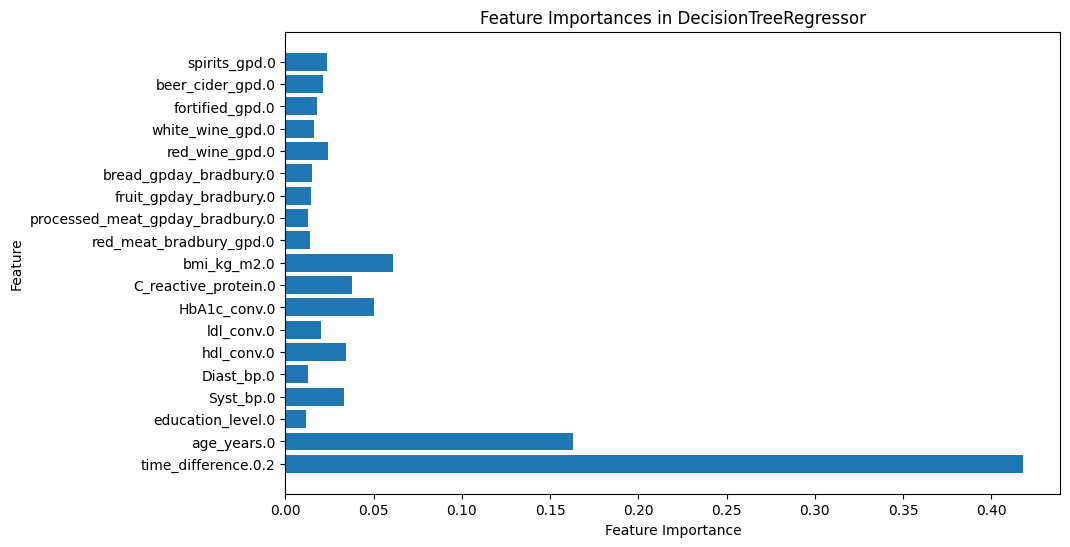

In [33]:
# global change on pm, min samples == 900, min elaf = 10. long but reasonable
regressor = DecisionTreeRegressor(min_samples_split = 800, min_samples_leaf = 100, 
                                             random_state = RANDOM_STATE)
regression_tree_model = regressor.fit(X_train,y_train)

print(f"MAE train:\n\t: {mean_absolute_error(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"MAE validation:\n\t: {mean_absolute_error(regression_tree_model.predict(X_val),y_val):.4f}")
print(f"MSE train:\n\t: {mean_squared_error(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"MSE validation:\n\t: {mean_squared_error(regression_tree_model.predict(X_val),y_val):.4f}")
print(f"R2 train:\n\t: {r2_score(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"R2 validation:\n\t: {r2_score(regression_tree_model.predict(X_val),y_val):.4f}")


# Retrieve the feature importances
importances = regression_tree_model.feature_importances_

# Print the feature importances
important_features = []
important_importances = []
for feature_name, importance in zip(features, importances):
    if importance > 0:
        print(f"Feature: {feature_name}, Importance: {importance}")
        important_features.append(feature_name)
        important_importances.append(importance)
        

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.barh(important_features, important_importances, align='center')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances in DecisionTreeRegressor")
plt.show()

In [ ]:
# adjusting colors
values = regressor.tree_.value.flatten()
# Normalize the values for coloring
norm = plt.Normalize(values.min(), values.max())
# Create a custom color map (green to red)
cmap = mcolors.LinearSegmentedColormap.from_list("GreenYellowRed", ["red", "yellow", "green"])

# Generate colors for each node based on the normalized values and the custom color map
colors = cmap(norm(values))

In [ ]:
'''plt.figure(figsize=(96, 64))
plot_tree(regressor,
            filled=True,
            rounded=True,
            proportion=True, 
            feature_names=features)

# Apply custom colors
ax = plt.gca()
for idx, leaf in enumerate(ax.collections):
    leaf.set_facecolor(colors[idx])

plt.show()'''

In [ ]:
'''dot_data = export_graphviz(regression_tree_model, out_file=None, 
                           filled=True, feature_names=features, rounded=True, special_characters=True,
                           proportion=True)

# Render the DOT file with Graphviz
graph = graphviz.Source(dot_data)
graph.render("regression_tree", format='png')
graph.view()'''

In [ ]:
dot_data_1 = export_graphviz(regressor,  out_file=None, filled=True, rounded=True, special_characters=True,
                           feature_names=features,
                           proportion=True)


# Split the DOT data into lines
dot_lines = dot_data_1.splitlines()
hex_color_pattern = r'fillcolor="#[0-9a-fA-F]{6}"'

# Modify the DOT file lines to include custom colors
new_dot_lines = []
for line in dot_lines:
    if 'fillcolor' in line:
        parts = line.split()
        if parts[0].isdigit():
            node_id = int(parts[0])
            # Get corresponding color
            color = mcolors.to_hex(colors[node_id])
            # Modify the line to include the color
            line = re.sub(hex_color_pattern, f'fillcolor="{color}"', line)
    new_dot_lines.append(line)

# Combine the modified lines back into a single string
new_dot_data = "\n".join(new_dot_lines)

# Render the DOT file with Graphviz
graph = graphviz.Source(new_dot_data)
graph.render(f"regression_tree_custom_color_{outcome}", format='png')
graph.view()

In [ ]:
# per case evaluation case beta-blockers numeric memory for the outcome nm
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["beta_blockers.0"].gt(0.5)]

print(f"size train case: {len(df_case_train)}")

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")

n_train_inside = (df_case_train[outcome].ge(mean_-error_) & df_case_train[outcome].le(mean_+error_)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train)
print(f"percentage train inside the interval: {percentage_tr_inside:.2f}")
# case specific 
n_hypertension = df_case_train["Hypertension.0"].eq(1).sum()
print(f"hypertension_patients_beta_blocker_case_tr: {n_hypertension}") 

df_case_valid = pd.concat([X_val, y_val], axis=1)

df_case_valid= df_case_valid[df_case_valid["beta_blockers.0"].gt(0.5)]

print(f"size val case: {len(df_case_valid)}")

n_val_inside = (df_case_valid[outcome].ge(mean_-error_) & df_case_valid[outcome].le(mean_+error_)).sum()
percentage_val_inside = (n_val_inside * 100)/len(df_case_valid)
print(f"percentage val inside the interval: {percentage_val_inside:.2f}")

n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")
n_hypertension_valid = df_case_valid["Hypertension.0"].eq(1).sum()
print(f"hypertension_patients_beta_blocker_case_valid: {n_hypertension_valid}")

df_case_all = df[df["beta_blockers.0"].gt(0.5)]
df_case_all.to_csv(f"data_case_nm_beta_blockers.csv")

In [ ]:
num = 3.14159
print(f"Formatted number: {num:.2f}")

In [ ]:
# per case evaluation case beta-blockers
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["age_years.0"].le(52.5) & df_case_train["age_years.0"].gt(46.5) & 
                             df_case_train["time_difference.0.2"].le(3468.5) & df_case_train["time_difference.0.2"].gt(1965.5) & 
                             df_case_train["beta_blockers.0"].gt(0.5)]

print(f"size train case: {len(df_case_train)}")

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")

n_train_inside = (df_case_train[outcome].ge(mean_-error_) & df_case_train[outcome].le(mean_+error_)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train)
print(f"percentage train inside the interval: {percentage_tr_inside:.2f}")
# case specific 
n_hypertension = df_case_train["Hypertension.0"].eq(1).sum()
print(f"hypertension_patients_beta_blocker_case_tr: {n_hypertension}") 

df_case_valid = pd.concat([X_val, y_val], axis=1)

df_case_valid= df_case_valid[df_case_valid["age_years.0"].le(52.5) & df_case_valid["age_years.0"].gt(46.5) & 
                             df_case_valid["time_difference.0.2"].le(3468.5) & df_case_valid["time_difference.0.2"].gt(1965.5) & 
                             df_case_valid["beta_blockers.0"].gt(0.5)]

print(f"size val case: {len(df_case_valid)}")

n_val_inside = (df_case_valid[outcome].ge(mean_-error_) & df_case_valid[outcome].le(mean_+error_)).sum()
percentage_val_inside = (n_val_inside * 100)/len(df_case_valid)
print(f"percentage val inside the interval: {percentage_val_inside:.2f}")

n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")
n_hypertension_valid = df_case_valid["Hypertension.0"].eq(1).sum()
print(f"hypertension_patients_beta_blocker_case_valid: {n_hypertension_valid}") 

In [ ]:
# per case evaluation case women bmi
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["age_years.0"].le(52.5) & df_case_train["age_years.0"].gt(46.5) & 
                             df_case_train["time_difference.0.2"].gt(3468.5) & df_case_train["gender.0"].gt(0.5) & 
                             df_case_train["bmi_kg_m2.0"].le(19.482)]

print(f"size train case: {len(df_case_train)}")

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")

n_train_inside = (df_case_train[outcome].ge(mean_-error_) & df_case_train[outcome].le(mean_+error_)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train)
print(f"percentage train inside the interval: {percentage_tr_inside:.2f}")
# case specific 


df_case_valid = pd.concat([X_val, y_val], axis=1)

df_case_valid= df_case_valid[df_case_valid["age_years.0"].le(52.5) & df_case_valid["age_years.0"].gt(46.5) & 
                             df_case_valid["time_difference.0.2"].gt(3468.5) & df_case_valid["gender.0"].gt(0.5) & 
                             df_case_valid["bmi_kg_m2.0"].le(19.482)]

print(f"size val case: {len(df_case_valid)}")

n_val_inside = (df_case_valid[outcome].ge(mean_-error_) & df_case_valid[outcome].le(mean_+error_)).sum()
percentage_val_inside = (n_val_inside * 100)/len(df_case_valid)
print(f"percentage val inside the interval: {percentage_val_inside:.2f}")

n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")


In [ ]:
# per case evaluation case women waist
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["age_years.0"].gt(52.5) & df_case_train["age_years.0"].le(59.5) &
                             df_case_train["time_difference.0.2"].gt(3482.5) & df_case_train["gender.0"].gt(0.5) & 
                             df_case_train["waist_cm.0"].gt(113.5)]

print(f"size train case: {len(df_case_train)}")

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")

n_train_inside = (df_case_train[outcome].ge(mean_-error_) & df_case_train[outcome].le(mean_+error_)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train)
print(f"percentage train inside the interval: {percentage_tr_inside:.2f}")
# case specific 


df_case_valid = pd.concat([X_val, y_val], axis=1)

df_case_valid= df_case_valid[df_case_valid["age_years.0"].gt(52.5) & df_case_valid["age_years.0"].le(59.5) &
                             df_case_valid["time_difference.0.2"].gt(3482.5) & df_case_valid["gender.0"].gt(0.5) & 
                             df_case_valid["waist_cm.0"].gt(113.5)]

print(f"size val case: {len(df_case_valid)}")

n_val_inside = (df_case_valid[outcome].ge(mean_-error_) & df_case_valid[outcome].le(mean_+error_)).sum()
percentage_val_inside = (n_val_inside * 100)/len(df_case_valid)
print(f"percentage val inside the interval: {percentage_val_inside:.2f}")

n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")


In [ ]:
# per case evaluation case women ldl
df_case_train = pd.concat([X_train, y_train], axis=1)
df_case_train= df_case_train[df_case_train["age_years.0"].gt(59.5) &
                             df_case_train["time_difference.0.2"].le(3543.5) & df_case_train["gender.0"].gt(0.5) & 
                             df_case_train["ldl_conv.0"].le(113.565)]

print(f"size train case: {len(df_case_train)}")

mean_ = df_case_train[outcome].mean()
print(f"mean train case: {mean_}")
error_ = df_case_train[outcome].std()
print(f"std train case: {error_}")
min_ = df_case_train[outcome].min()
print(f"min train case: {min_}")
max_ = df_case_train[outcome].max()
print(f"max train case: {max_}")

n_train_inside = (df_case_train[outcome].ge(mean_-error_) & df_case_train[outcome].le(mean_+error_)).sum()
percentage_tr_inside = (n_train_inside * 100)/len(df_case_train)
print(f"percentage train inside the interval: {percentage_tr_inside:.2f}")
# case specific 
print(f"mean ldl: {df_case_train['ldl_conv.0'].mean()}")
print(f"median ldl: {df_case_train['ldl_conv.0'].median()}")
print(f"min ldl: {df_case_train['ldl_conv.0'].min()}")
print(f"max ldl: {df_case_train['ldl_conv.0'].max()}")

df_case_valid = pd.concat([X_val, y_val], axis=1)

df_case_valid= df_case_valid[df_case_valid["age_years.0"].gt(59.5) &
                             df_case_valid["time_difference.0.2"].le(3543.5) & df_case_valid["gender.0"].gt(0.5) & 
                             df_case_valid["ldl_conv.0"].le(113.565)]

print(f"size val case: {len(df_case_valid)}")

n_val_inside = (df_case_valid[outcome].ge(mean_-error_) & df_case_valid[outcome].le(mean_+error_)).sum()
percentage_val_inside = (n_val_inside * 100)/len(df_case_valid)
print(f"percentage val inside the interval: {percentage_val_inside:.2f}")

n_val_min_max = (df_case_valid[outcome].ge(min_) & df_case_valid[outcome].le(max_)).sum()
percentage_val_min_max = (n_val_min_max * 100)/len(df_case_valid )
print(f"percentage val inside the train min max: {percentage_val_min_max:.2f}")

# case specific 
print(f"valid mean ldl: {df_case_valid['ldl_conv.0'].mean()}")
print(f"valid median ldl: {df_case_valid['ldl_conv.0'].median()}")
print(f"valid min ldl: {df_case_valid['ldl_conv.0'].min()}")
print(f"valid max ldl: {df_case_valid['ldl_conv.0'].max()}")


In [ ]:
'''dot_data_val = export_graphviz(regression_tree_val_model, out_file=None, 
                           filled=True, feature_names=features,
                           proportion=True)

# Render the DOT file with Graphviz
graph_val = graphviz.Source(dot_data_val)
graph_val.render("regression_tree_val", format='png')
graph_val.view()'''

In [ ]:
print(f"MAE train:\n\t: {mean_absolute_error(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"MAE validation:\n\t: {mean_absolute_error(regression_tree_model.predict(X_val),y_val):.4f}")
print(f"R2 train:\n\t: {r2_score(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"R2 validation:\n\t: {r2_score(regression_tree_model.predict(X_val),y_val):.4f}")

In [ ]:
print(f"R2 train:\n\t: {r2_score(regression_tree_model.predict(X_train),y_train):.4f}")
print(f"R2 validation:\n\t: {r2_score(regression_tree_model.predict(X_val),y_val):.4f}")

In [ ]:
n_estimators_list = [10,50,100,500]

In [ ]:
mae_list_train = []
r2_list_train = []
mae_list_val = []
r2_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestRegressor(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    mae_train = mean_absolute_error(predictions_train,y_train)
    mae_val = mean_absolute_error(predictions_val,y_val)
    
    r2_train = r2_score(predictions_train,y_train)
    r2_val = r2_score(predictions_val,y_val)
    
    mae_list_train.append(mae_train)
    mae_list_val.append(mae_val)
    
    r2_list_train.append(r2_train)
    r2_list_val.append(r2_val)


In [ ]:
plt.title("Train x Validation MAE")
plt.xlabel('n_estomators')
plt.ylabel('MAE')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(mae_list_train)
plt.plot(mae_list_val)
plt.legend(['Train','Validation'])

In [ ]:
plt.title('Train x Validation R2')
plt.xlabel('n_estimators')
plt.ylabel('R2')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(r2_list_train)
plt.plot(r2_list_val)
plt.legend(['Train','Validation'])

In [ ]:
regression_forest_model = RandomForestRegressor(n_estimators = 10,
                                             max_depth = 6, 
                                             min_samples_split = 50).fit(X_train,y_train)

In [ ]:
print(f"MAE train:\n\t: {mean_absolute_error(regression_forest_model.predict(X_train),y_train):.4f}")
print(f"MAE validation:\n\t: {mean_absolute_error(regression_forest_model.predict(X_val),y_val):.4f}")
print(f"R2 train:\n\t: {r2_score(regression_forest_model.predict(X_train),y_train):.4f}")
print(f"R2 validation:\n\t: {r2_score(regression_forest_model.predict(X_val),y_val):.4f}")

In [ ]:
xgb_model = XGBRegressor(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train,y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 10)

In [ ]:
print(xgb_model.best_iteration)

In [ ]:
print(f"MAE train:\n\t: {mean_absolute_error(xgb_model.predict(X_train),y_train):.4f}")
print(f"MAE validation:\n\t: {mean_absolute_error(xgb_model.predict(X_val),y_val):.4f}")
print(f"R2 train:\n\t: {r2_score(xgb_model.predict(X_train),y_train):.4f}")
print(f"R2 validation:\n\t: {r2_score(xgb_model.predict(X_val),y_val):.4f}")